# Capstone project
for Zoomcamp, Ahmed Yahia Kallel

In [59]:
# run pip to get requirement.txt
!pip install -r requirements.txt

In [60]:
#import main libraries

#processing & viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.metrics import auc, roc_curve

# Data loading, preparation, cleaning


## Load data
load csv file

In [61]:
df = pd.read_csv("Property Prices in Tunisia.csv") #load file
df #head/tail

,category,room_count,bathroom_count,size,type,price,city,region,log_price
0,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,100000.0,Ariana,Raoued,5.000000
1,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,316000.0,Ariana,Autres villes,5.499687
2,Appartements,2.0,1.0,80.0,À Louer,380.0,Ariana,Autres villes,2.579784
3,Locations de vacances,1.0,1.0,90.0,À Louer,70.0,Ariana,Autres villes,1.845098
4,Appartements,2.0,2.0,113.0,À Vendre,170000.0,Ariana,Ariana Ville,5.230449
...,...,...,...,...,...,...,...,...,...
12743,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,3200000.0,Tunis,Sidi Bou Said,6.505150
12744,Appartements,1.0,1.0,100.0,À Louer,600.0,Tunis,Autres villes,2.778151
12745,Maisons et Villas,3.0,1.0,760.0,À Vendre,1950000.0,Tunis,La Marsa,6.290035
12746,Maisons et Villas,3.0,1.0,190.0,À Vendre,240000.0,Tunis,La Marsa,5.380211


Since my colleagues would mind if this was french, I'll be translating it :)

## Translation

In [62]:
df.replace(df["category"].unique(), ['Land and Farms', 'Apartments', 'Holiday rentals',
       'Shops, Businesses and Industrial Premises', 'Houses and Villas',
       'Flatshare', 'Offices and Trays'],inplace=True)

df.replace(df["type"].unique(), ['For sale', 'For rent'],inplace=True)

df.replace("Autres villes","Others", inplace=True)
df

,category,room_count,bathroom_count,size,type,price,city,region,log_price
0,Land and Farms,-1.0,-1.0,-1.0,For sale,100000.0,Ariana,Raoued,5.000000
1,Land and Farms,-1.0,-1.0,-1.0,For sale,316000.0,Ariana,Others,5.499687
2,Apartments,2.0,1.0,80.0,For rent,380.0,Ariana,Others,2.579784
3,Holiday rentals,1.0,1.0,90.0,For rent,70.0,Ariana,Others,1.845098
4,Apartments,2.0,2.0,113.0,For sale,170000.0,Ariana,Ariana Ville,5.230449
...,...,...,...,...,...,...,...,...,...
12743,Land and Farms,-1.0,-1.0,-1.0,For sale,3200000.0,Tunis,Sidi Bou Said,6.505150
12744,Apartments,1.0,1.0,100.0,For rent,600.0,Tunis,Others,2.778151
12745,Houses and Villas,3.0,1.0,760.0,For sale,1950000.0,Tunis,La Marsa,6.290035
12746,Houses and Villas,3.0,1.0,190.0,For sale,240000.0,Tunis,La Marsa,5.380211


12748 uniques entries, 7 features, 2 continuous output (price)

In [63]:
#del df["price"] #since we'll be using log price anyway (will be done after visualization)




## checking NA

In [64]:
df.isna().sum()

category          0
room_count        0
bathroom_count    0
size              0
type              0
price             0
city              0
region            0
log_price         0
dtype: int64

In [65]:
df.isnull().sum()

category          0
room_count        0
bathroom_count    0
size              0
type              0
price             0
city              0
region            0
log_price         0
dtype: int64

In this database, the "NA" is -1

In [66]:
(df==-1).sum()

category             0
room_count        3415
bathroom_count    3415
size              3415
type                 0
price                0
city                 0
region               0
log_price            0
dtype: int64

Here, 3415 values are missing. 

* ***Question 1*: are they from the same samples?**

In [67]:
na_vals = ((df["room_count"] == -1).astype(np.bool) & (df["bathroom_count"]==-1).astype(np.bool)) & (df["size"]==-1).astype(np.bool)
na_vals.sum()

3415

**=> Yes**

* ***Question 2*: does removing them cause problems?**

In [68]:
df[na_vals].category.unique()

array(['Land and Farms'], dtype=object)

Makes sense ... "Land and farms" shouldn't have room count or room size :-/


There are two possible options/consequences:
- remove the land & farms
- let land and farms in place and check their "influence"


I have chosen option 2

# Data info & visualization (General)

In [12]:
def plot_and_describe_pie(feature_name):
    (df.groupby(feature_name)[feature_name].count()/len(df)*100).plot.pie(y=feature_name,figsize=(10,8),ylabel='share in %', autopct='%.2f')
    print("Share Count");
    print(df.groupby(feature_name)[feature_name].count())
    print("\r\nShare in %:");
    print(df.groupby(feature_name)[feature_name].count()/len(df)*100)

def plot_and_describe_bar(feature_name):
    (df.replace(-1,"N/A").groupby(feature_name)[feature_name].count()/len(df)*100).plot.bar(y=feature_name,figsize=(10,8),ylabel='share in %')
    print("Share Count");
    print(df.replace(-1,"N/A").groupby(feature_name)[feature_name].count())
    print("\r\nShare in %:");
    print(df.replace(-1,"N/A").groupby(feature_name)[feature_name].count()/len(df)*100)

def plot_and_describe_qhist(feature_name, bin_count=10):
    it =  (pd.qcut(df[feature_name],q=bin_count,duplicates='drop').value_counts()) #temporary
    (it/ len(df)*100).plot.bar(ylabel='share in %',figsize=(8,6))
    print("Share Count");
    print(it)
    print("\r\nShare in %:");
    print(it/len(df)*100)

Excluding the -1, the description of the database:

In [13]:
#generate description
df[df!=-1].describe()

,room_count,bathroom_count,size,price,log_price
count,9333.000000,9333.000000,9333.000000,1.274800e+04,12748.000000
mean,2.769420,1.403836,179.157827,1.601575e+07,4.374245
std,1.623003,0.798154,193.874968,1.016644e+09,1.389788
min,1.000000,0.000000,20.000000,1.000000e+01,1.000000
25%,2.000000,1.000000,83.000000,8.500000e+02,2.929419
50%,3.000000,1.000000,120.000000,8.975000e+04,4.953033
75%,3.000000,2.000000,198.000000,2.600000e+05,5.414973
max,20.000000,10.000000,2000.000000,1.000000e+11,11.000000


## category

Share Count
category
Apartments                                   4700
Flatshare                                      65
Holiday rentals                               298
Houses and Villas                            3158
Land and Farms                               3415
Offices and Trays                             461
Shops, Businesses and Industrial Premises     651
Name: category, dtype: int64

Share in %:
category
Apartments                                   36.868528
Flatshare                                     0.509884
Holiday rentals                               2.337622
Houses and Villas                            24.772513
Land and Farms                               26.788516
Offices and Trays                             3.616254
Shops, Businesses and Industrial Premises     5.106683
Name: category, dtype: float64


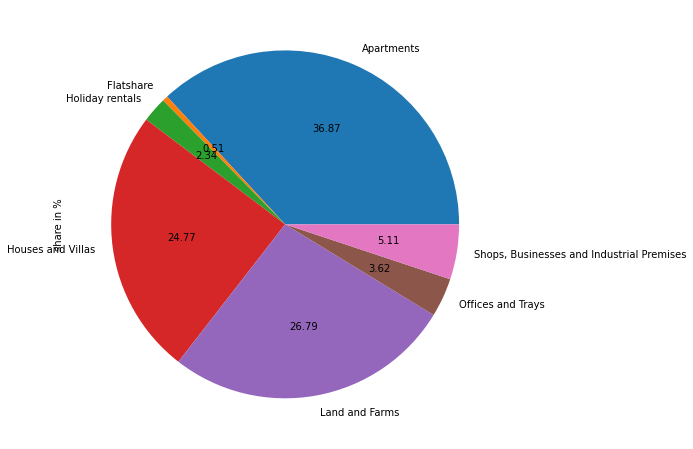

In [14]:
plot_and_describe_pie("category")

There are 7 categories: "apartments" (flats), "lands & farms", and "house & villas" are the most dominant. 

## Type

Share Count
type
For rent    4990
For sale    7758
Name: type, dtype: int64

Share in %:
type
For rent    39.143395
For sale    60.856605
Name: type, dtype: float64


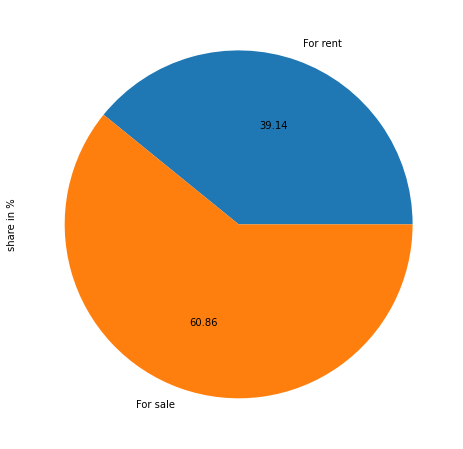

In [15]:
plot_and_describe_pie("type")

## Room count

Share Count
room_count
1.0     1699
2.0     2906
3.0     2702
4.0     1160
5.0      385
6.0      205
7.0       87
8.0       88
9.0       29
10.0      27
11.0      10
12.0      16
13.0       5
14.0       6
15.0       2
16.0       1
18.0       3
20.0       2
N/A     3415
Name: room_count, dtype: int64

Share in %:
room_count
1.0     13.327581
2.0     22.795733
3.0     21.195482
4.0      9.099467
5.0      3.020082
6.0      1.608095
7.0      0.682460
8.0      0.690304
9.0      0.227487
10.0     0.211798
11.0     0.078444
12.0     0.125510
13.0     0.039222
14.0     0.047066
15.0     0.015689
16.0     0.007844
18.0     0.023533
20.0     0.015689
N/A     26.788516
Name: room_count, dtype: float64


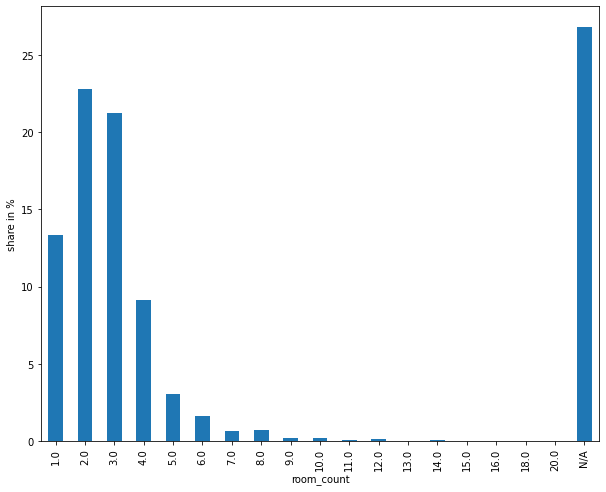

In [16]:
plot_and_describe_bar('room_count')

In [17]:
#df['room_count'].median()
# df['room_count'].mean()
df['room_count'].describe()

count    12748.000000
mean         1.759649
std          2.171468
min         -1.000000
25%         -1.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: room_count, dtype: float64

In most cases, and aside the "farms & lands" that do not have a room count, the mode is 2 rooms per reality estate. 
* The minimum is 0
* Maximum is 20 (wow... is that a castle?)
* median and mode are both 2 (average is 1.76 [joke: imagine if you have a neighbor sharing 25% of your second room], rounded to 2)


**Cautions: starting from ```Room_count``` of 14, there is a probability of data degeneracy** (check table above)

## bathroom count

Share Count
bathroom_count
0.0       36
1.0     6582
2.0     2012
3.0      484
4.0      133
5.0       51
6.0       12
7.0        9
8.0        9
10.0       5
N/A     3415
Name: bathroom_count, dtype: int64

Share in %:
bathroom_count
0.0      0.282397
1.0     51.631628
2.0     15.782868
3.0      3.796674
4.0      1.043301
5.0      0.400063
6.0      0.094132
7.0      0.070599
8.0      0.070599
10.0     0.039222
N/A     26.788516
Name: bathroom_count, dtype: float64


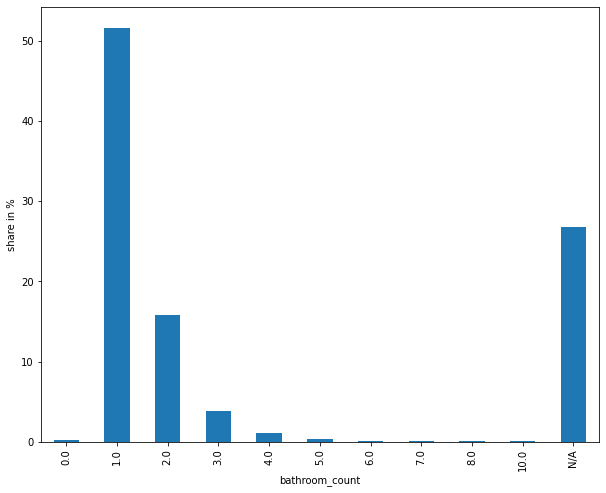

In [18]:
plot_and_describe_bar('bathroom_count')

In [19]:
df["bathroom_count"].describe()

count    12748.000000
mean         0.759884
std          1.264812
min         -1.000000
25%         -1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: bathroom_count, dtype: float64

* Minimum of 0 bathrooms (probably shared, I think?? I hope??)
* Maximum of 10 bathrooms per household (I told you this is a castle!!)
* Mode and median are 1
* Average of 0.75 (yes, 25% remaining of my toilet seat is owned by my neighbor. This is why we made it clear that they should only enter during the first 6 hours of the day /joke)

In [20]:
df[df["bathroom_count"]==0].groupby("category")["category"].count()

category
Offices and Trays                             3
Shops, Businesses and Industrial Premises    33
Name: category, dtype: int64

OK, so some shops, business, offices do not have a toilet.... 

Let's not think hard about it and continue working

## Size

Share Count
(-1.001, 48.0]     3830
(134.0, 180.0]     1368
(48.0, 75.0]       1347
(95.0, 110.0]      1342
(180.0, 300.0]     1235
(75.0, 95.0]       1226
(300.0, 2000.0]    1211
(110.0, 134.0]     1189
Name: size, dtype: int64

Share in %:
(-1.001, 48.0]     30.043928
(134.0, 180.0]     10.731095
(48.0, 75.0]       10.566363
(95.0, 110.0]      10.527142
(180.0, 300.0]      9.687794
(75.0, 95.0]        9.617195
(300.0, 2000.0]     9.499529
(110.0, 134.0]      9.326953
Name: size, dtype: float64


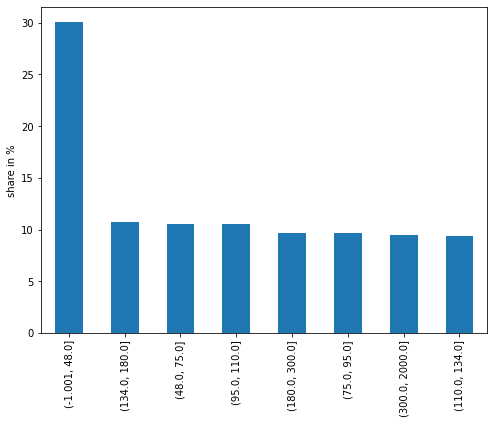

In [21]:
plot_and_describe_qhist('size')

In [22]:
df[df!=-1]["size"].describe()

count    9333.000000
mean      179.157827
std       193.874968
min        20.000000
25%        83.000000
50%       120.000000
75%       198.000000
max      2000.000000
Name: size, dtype: float64

So basically tiny (< 48m²) & no size have a share of 30%. 
* Average of 179m² is shown, but the median is 120m²
* Maximum of 2000 m² (0.2 hectare²) size
* Minimum is 20 m²  (well... my uni-room abroad is 18m², I can't complain I guess)
* 75% percentile  have 198 m² or less size

## City

Share Count
city
Ariana         2374
Ben arous      1123
Bizerte         455
Béja             63
Gabès           191
Gafsa            88
Jendouba         92
Kairouan        116
Kasserine        59
Kébili           11
La manouba      663
Le kef           63
Mahdia          268
Monastir        479
Médenine        230
Nabeul          821
Sfax            646
Sidi bouzid      53
Siliana          31
Sousse         2270
Tataouine        17
Tozeur           46
Tunis          2408
Zaghouan        181
Name: city, dtype: int64

Share in %:
city
Ariana         18.622529
Ben arous       8.809225
Bizerte         3.569187
Béja            0.494195
Gabès           1.498274
Gafsa           0.690304
Jendouba        0.721682
Kairouan        0.909947
Kasserine       0.462818
Kébili          0.086288
La manouba      5.200816
Le kef          0.494195
Mahdia          2.102291
Monastir        3.757452
Médenine        1.804205
Nabeul          6.440226
Sfax            5.067462
Sidi bouzid     0.415751
Siliana   

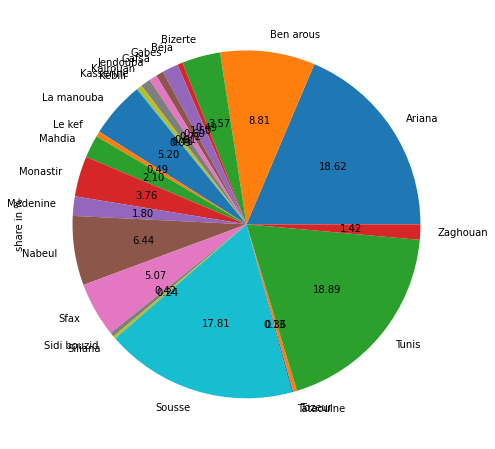

In [23]:
plot_and_describe_pie('city')


In [24]:
#grand_tunis = ((df["city"] == 'Ariana') | (df["city"] == 'Tunis') | (df["city"] == 'Ben arous')   | (df["city"] == 'La manouba'))
#grand_tunis.sum() / len(df)*100

# sahel = ((df["city"] == 'Monastir') | (df["city"] == 'Mahdia') | (df["city"] == 'Sousse') )
# sahel.sum() / len(df)*100

#nord_ouest = ((df["city"] == 'Béja') | (df["city"] == 'Jendouba') | (df["city"] == 'Siliana')  | (df["city"] == 'Le kef') )
# #nord_ouest.sum() / len(df)*100

#nord_est = ((df["city"] == 'Nabeul') | (df["city"] == 'Bizerte') | (df["city"] == 'Zaghouan') ) 
#nord_est.sum() / len(df)*100

#centre_est = ((df["city"] == 'Kairouan') | (df["city"] == 'Kasserine') | (df["city"] == 'Sidi bouzid') ) 
#centre_est.sum() / len(df)*100

sud_ouest = ((df["city"] == 'Tozeur') | (df["city"] == 'Kébili') | (df["city"] == 'Gafsa') ) 
sud_est = ((df["city"] == 'Gabès') | (df["city"] == 'Médenine') | (df["city"] == 'Tataouine') ) 
(sud_ouest|sud_est).sum() / len(df)*100

4.573266394728584

In [25]:
#df.groupby("city")["city"].count().sort_values(ascending=False)
df.groupby("city")["city"] == 'Ariana'


False

Since this is my home country, I'll explain it better:
* The capital "Tunis" has most offers (18.89%)
* The "metropole" ; Grand Tunis, which contains Ariana, Tunis, Mannouba, and Ben Arous; has 51% offers
* The "Sahel"; Shore/Coast region, which contains Monastir, Sousse, and Mahdia, has 23% offers
* Nabeul; from Napolis; has 6% offers, but if we include "North east" (Nabeul+Bizerte+Zaghouan): 11%
* The "Capital of the South"; Sfax; has 5% offers; but if it's added to Sahel to form the "center-east": 16%
* The Nord-Ouest (Béja + Le Kef + Jendouba + Siliana): 1.95 % of the offers
* Center-west (Kairouan, Kasserine & Sidi Bouzid): 1.75% of the offers
* South (excluding Sfax): 4.57% of the offers

_if interested, offtopic_
* South has Tataouine (Yes, where Tatooine from Star Wars was shot) but it's a bit hot
* Monastir, Sousse, Mahdia, and Sfax contains many roman monuments, Life of Brian was shot in Monastir, for example

## Region

In [26]:
print(df.groupby(['city','region'])["region"].count().to_string())

city         region                  
Ariana       Ariana                      155
             Ariana Ville                 95
             Borj Louzir                 158
             Chotrana                     86
             Ennasr                      304
             Ettadhamen                   10
             Ghazela                     183
             Jardins D'el Menzah         149
             La Soukra                   446
             Mnihla                       74
             Others                      356
             Raoued                      268
             Sidi Thabet                  90
Ben arous    Ben arous                    45
             Boumhel                     162
             El Mourouj                  193
             Ezzahra                      94
             Fouchana                     48
             Hammam Chott                 93
             Hammam Lif                   32
             Medina Jedida                68
             Moha

The database has some deficiency in the "region", it must be proceed with caution.

In some cities (such as Le Kef), only one sample per region could be found. Therefore, during training or testing, this could become very lethal!

**Otherwise said: We hope that ***city*** could be enough to get a good place range, but, for some cities, regions aren't enough to provide a good result.**

## Price

Share Count
(89750.0, 150000.0]          1455
(380.0, 650.0]               1306
(9.999, 380.0]               1295
(650.0, 1200.0]              1295
(320000.0, 600000.0]         1274
(24000.0, 89750.0]           1273
(600000.0, 99999999999.0]    1260
(1200.0, 24000.0]            1205
(220000.0, 320000.0]         1199
(150000.0, 220000.0]         1186
Name: price, dtype: int64

Share in %:
(89750.0, 150000.0]          11.413555
(380.0, 650.0]               10.244744
(9.999, 380.0]               10.158456
(650.0, 1200.0]              10.158456
(320000.0, 600000.0]          9.993725
(24000.0, 89750.0]            9.985880
(600000.0, 99999999999.0]     9.883903
(1200.0, 24000.0]             9.452463
(220000.0, 320000.0]          9.405397
(150000.0, 220000.0]          9.303420
Name: price, dtype: float64


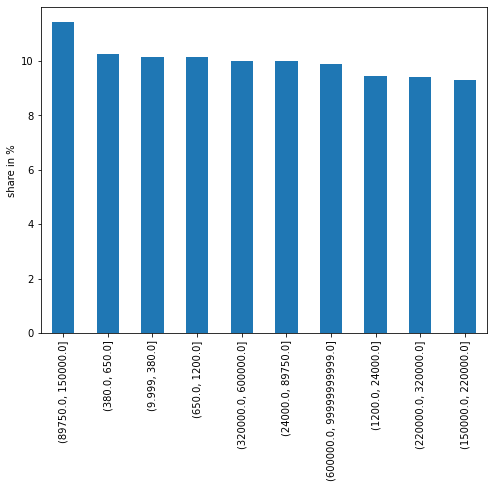

In [27]:
plot_and_describe_qhist('price')

In [28]:
df.price.describe()

count    1.274800e+04
mean     1.601575e+07
std      1.016644e+09
min      1.000000e+01
25%      8.500000e+02
50%      8.975000e+04
75%      2.600000e+05
max      1.000000e+11
Name: price, dtype: float64

Prices: (is around TND= 1/3 euros/dollars)
- Min: 10 TND
- Max: 10^11 TND (hmm, yes, it's a castle!)
- average of 16 (in billions TND)
- median of 89 (in millions TND)

In [58]:
del df["price"] #since we'll be using log price anyway (will be done after visualization)

KeyError: 'price'

# Data splitting (training/validation/test)
split the data into training/val/test: 60/20/20

In [30]:
#split according to random state = 1
df_trainval, df_test = train_test_split(df, test_size=0.2, random_state=1) #split train+val [80%], test [20%]
df_train, df_val = train_test_split(df_trainval, test_size=0.25, random_state=1) #split train[60%] val [20%]

#reset, drop index
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_test = df_test["log_price"].values
y_train = df_train["log_price"].values
y_val = df_val["log_price"].values

del df_test["log_price"]
del df_train["log_price"]
del df_val["log_price"]

df_train

,category,room_count,bathroom_count,size,type,city,region
0,Houses and Villas,2.0,1.0,110.0,For sale,Ben arous,Hammam Chott
1,Apartments,2.0,1.0,70.0,For rent,Tunis,L'aouina
2,Apartments,2.0,1.0,80.0,For sale,Tunis,Tunis
3,Land and Farms,-1.0,-1.0,-1.0,For sale,Monastir,Others
4,Apartments,2.0,1.0,56.0,For sale,Jendouba,Tabarka
...,...,...,...,...,...,...,...
7643,Land and Farms,-1.0,-1.0,-1.0,For sale,Sfax,Others
7644,Houses and Villas,1.0,8.0,84.0,For rent,Tunis,Others
7645,Houses and Villas,2.0,1.0,100.0,For rent,Ben arous,El Mourouj
7646,Land and Farms,-1.0,-1.0,-1.0,For sale,Monastir,Jemmal


## Check splitting

In [31]:
print("After splitting")
dfdesc = pd.DataFrame({ 'Name':["Training","Validation","Test"], 'Count': [len(df_train), len(df_val), len(df_test)]})
dfdesc["Percentage"] = dfdesc["Count"] *100 / len(df)
dfdesc["log_price (median)"] = [np.median(y_train),np.median(y_val),np.median(y_test)]
dfdesc["log_price (min)"] = [np.min(y_train),np.min(y_val),np.min(y_test)]
dfdesc["log_price (max)"] = [np.max(y_train),np.max(y_val),np.max(y_test)]
dfdesc

After splitting


,Name,Count,Percentage,log_price (median),log_price (min),log_price (max)
0,Training,7648,59.993725,4.929419,1.0,10.740363
1,Validation,2550,20.003138,4.929419,1.0,8.698970
2,Test,2550,20.003138,4.975426,1.0,11.000000


# Feature categorization 


In [32]:
feat_cat = ['category','type','city','region']
feat_num = ['room_count','bathroom_count','size']

print("Total Number of features are %d, %d are categorical and %d are numerical" %(len(df_train.columns),len(feat_cat), len(feat_num)))

Total Number of features are 7, 4 are categorical and 3 are numerical


# Features Analysis & Feature importance 

## Features analysis

### numerical

In [33]:
df_train.corr()

,room_count,bathroom_count,size
room_count,1.000000,0.846328,0.589139
bathroom_count,0.846328,1.000000,0.587654
size,0.589139,0.587654,1.000000


Well... I mean, 84% correlation is probably ok, for 20 room and 10 bathrooms 

### categorical

#### Category

In [34]:
w = list()
for cati in feat_cat:
    v = list()
    for catj in feat_cat:
        v.append(mutual_info_score(df[cati],df[catj]))
    w.append(v)
pd.DataFrame(w,index=feat_cat,columns=feat_cat)

,category,type,city,region
category,1.453092,0.212590,0.103830,0.236970
type,0.212590,0.669385,0.047319,0.094936
city,0.103830,0.047319,2.412546,1.979448
region,0.236970,0.094936,1.979448,4.182949


Nothing much to say here...  I mean they should be independent from each other...

## Feature importance

### numerical

In [35]:
#num_columns
df_train_x = df_train; #extended
df_train_x["log_price"] = y_train #return the log_price to database for a little bit!
df_train_x[feat_num].corrwith(df_train_x.log_price).abs()


room_count        0.126714
bathroom_count    0.207630
size              0.074403
dtype: float64

well.... the price has a slope of 0.12 and 0.2 (respectively) with the room count and bathroom_count, well yeah
But the size seems like it is not as relevant, I mean it's due to the sizing, but yes overall the room_count and bathroom_count are most important and perhaps seem to be more important than the size itself!

### categorical


C:\Users\kay_t\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\kay_t\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\kay_t\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  w

,price (log)
category,0.539796
type,0.648045
city,0.649260
region,1.659293


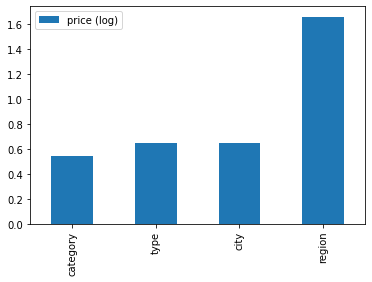

In [36]:
v= list()
for cati in feat_cat:
   v.append(mutual_info_score(df_train[cati], y_train))
cat_data_analy = pd.DataFrame(v,index= feat_cat,columns = ['price (log)'])

cat_data_analy.plot.bar()
cat_data_analy

in general, city-region, then the type impact the price. However, it's seen that category seems to be as important as the random classifier. Does this mean that category is not influencing the price much? 

# Regression part

In [37]:
from sklearn.pipeline import Pipeline

#transformers
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler


#models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import StackingRegressor


### Transformation

In [129]:
transformations = [
    #('numerical', 'passthrough', feat_num),
    #('Scal_num', StandardScaler() , feat_num),
    ('Scal_num', RobustScaler() , feat_num),
    ('categorical', OneHotEncoder(dtype=np.int32,handle_unknown = 'ignore'), feat_cat)
]

transf = ColumnTransformer(transformations, remainder='drop')

## comment for future me or future something looking for how to get things done by counting keywords into a string
# ('transf_name', CountVectorizer(token_pattern='.*', min_df=50, dtype='int32'), 'feature_name'),

Robust scaler performed better than standard scaler and no scaler at all

In [118]:
transf.fit(df_train)
X = transf.transform(df_train)

### Regression

In [135]:
def rmse(v):
    return np.sqrt(np.mean(v**2))

def eval_method(y_train,y_val,predictor,method_name):
    print(method_name)
    df_reg_res[method_name] = [rmse(y_train -  predictor(df_train)), rmse(y_val - predictor(df_val))]
    print('\tTraining RMSE: %2.3f ' % rmse(y_train -  predictor(df_train)))
    print('\tValidation RMSE: %2.3f ' % rmse(y_val - predictor(df_val)))

def eval_method_noadd(y_train,y_val,predictor):
   return [rmse(y_train -  predictor(df_train)), rmse(y_val - predictor(df_val))]


In [136]:
df_reg_res = pd.DataFrame(index=[['train','val']])
df_reg_res

""
train
val


#### linear regression

In [137]:
pipeline_linear_regression = Pipeline([
    ('transformer', transf),
    ('lr', LinearRegression())
])

In [138]:
pipeline_linear_regression.fit(df_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('Scal_num', RobustScaler(),
                                                  ['room_count',
                                                   'bathroom_count', 'size']),
                                                 ('categorical',
                                                  OneHotEncoder(dtype=<class 'numpy.int32'>,
                                                                handle_unknown='ignore'),
                                                  ['category', 'type', 'city',
                                                   'region'])])),
                ('lr', LinearRegression())])

In [139]:
eval_method(y_train,y_val,pipeline_linear_regression.predict,'LinearRegression-default')

LinearRegression-default
	Training RMSE: 0.522 
	Validation RMSE: 0.560 


#### Support Vector Machine

In [141]:
pipe_svr = Pipeline([
    ('transformer', transf),
    ('svr', SVR())
])
pipe_svr.fit(df_train, y_train)
eval_method(y_train,y_val,pipe_svr.predict,'SVR-default')
df_reg_res

SVR-default
	Training RMSE: 0.502 
	Validation RMSE: 0.545 


,LinearRegression-default,SVR-default
train,0.522273,0.502043
val,0.559898,0.545259


##### Let's do some trial-and-error parameter tuning
Here I'll be tuning the parameter, then the best will be added to the summary table.

SVR can have the C (1/lambda) and epsilon parameters tuned

In [142]:
svr_df = pd.DataFrame(columns=[['c','eps','train','val']])
for c in [0.1, 0.5, 0.8, 0.9, 1, 1.1 ,10]:
    for epsi in [0.09, 0.1, 0.11, 0.15, 0.2, 0.5,0.01]:
        pipe_svr_test = Pipeline([
         ('transformer', transf),
        ('svr', SVR(C=c, epsilon = epsi))
    ])
        pipe_svr_test.fit(df_train, y_train)
        v = eval_method_noadd(y_train,y_val,pipe_svr_test.predict)
        svr_df=svr_df.append({'c':c,'eps':epsi,'train':v[0],'val':v[1]},ignore_index=True)

<AxesSubplot:xlabel='None-eps', ylabel='c'>

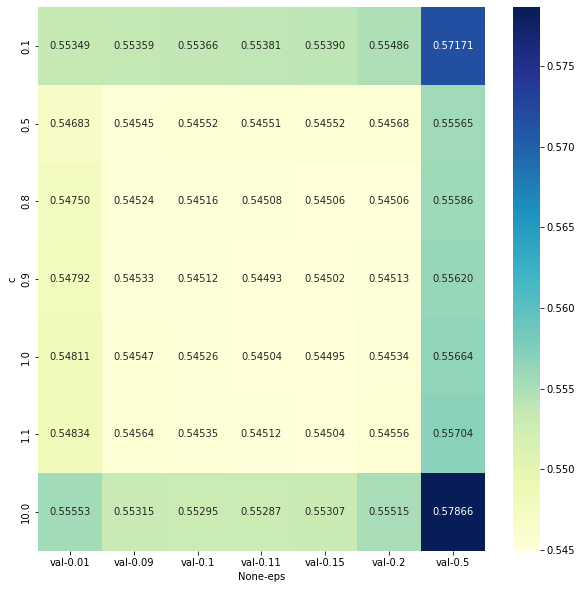

In [143]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
svr_df_piv = svr_df.pivot(index='c', columns=['eps'], values=["val"])
sns.heatmap(svr_df_piv, annot=True, fmt=".5f",ax=ax,cmap="YlGnBu")
#df_linclf_th007_pivot = df_linclf_th007.pivot(index='C', columns=['maxit'], values=['auc'])
# sns.heatmap(df_linclf_th007_pivot, annot=True, fmt=".5f")

In [144]:
pipe_svr = Pipeline([
    ('transformer', transf),
    ('svr', SVR(C=0.9,epsilon=0.15))
])
pipe_svr.fit(df_train, y_train)
eval_method(y_train,y_val,pipe_svr.predict,'SVR-C0.9eps0.15')

SVR-C0.9eps0.15
	Training RMSE: 0.503 
	Validation RMSE: 0.545 


#### Decision Tree Regressor

In [145]:
# speed run with default vals
pipeline = Pipeline([
    ('transformer', transf),
    ('dt', DecisionTreeRegressor())
])
pipeline.fit(df_train, y_train)
eval_method(y_train,y_val,pipeline.predict,'DT-default')
df_reg_res


DT-default
	Training RMSE: 0.344 
	Validation RMSE: 0.655 


,LinearRegression-default,SVR-default,SVR-C0.9eps0.15,DT-default
train,0.522273,0.502043,0.502613,0.344086
val,0.559898,0.545259,0.545021,0.655376


In [146]:
dt_df = pd.DataFrame(columns=[['maxdep','train','val']])
for maxd in np.arange(1,100):
        pipe_dt_test = Pipeline([
         ('transformer', transf),
        ('dt', DecisionTreeRegressor(max_depth=maxd))
    ])
        pipe_dt_test.fit(df_train, y_train)
        v = eval_method_noadd(y_train,y_val,pipe_dt_test.predict)
        dt_df=dt_df.append({'maxdep':maxd,'train':v[0],'val':v[1]},ignore_index=True)

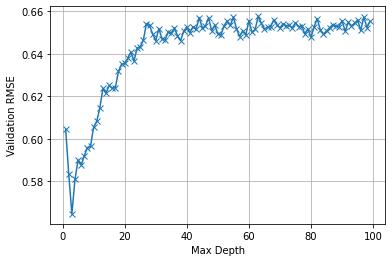

In [147]:
plt.plot(dt_df.maxdep,dt_df.val,'x-')
plt.xlabel('Max Depth')
plt.ylabel('Validation RMSE')
plt.grid(True)
plt.box(True)

In [148]:
# speed run with default vals
pipeline = Pipeline([
    ('transformer', transf),
    ('dt', DecisionTreeRegressor(max_depth=3))
])
pipeline.fit(df_train, y_train)
eval_method(y_train,y_val,pipeline.predict,'DT-maxdep3')
df_reg_res


DT-maxdep3
	Training RMSE: 0.563 
	Validation RMSE: 0.565 


,LinearRegression-default,SVR-default,SVR-C0.9eps0.15,DT-default,DT-maxdep3
train,0.522273,0.502043,0.502613,0.344086,0.562987
val,0.559898,0.545259,0.545021,0.655376,0.564742


#### Random Forest

In [149]:
# test run with default vals
pipeline_rfr_regression = Pipeline([
    ('transformer', transf),
    ('rfr', RandomForestRegressor())
])
pipeline_rfr_regression.fit(df_train, y_train)
eval_method(y_train,y_val,pipeline_rfr_regression.predict,'RF-default')
df_reg_res


RF-default
	Training RMSE: 0.373 
	Validation RMSE: 0.564 


,LinearRegression-default,SVR-default,SVR-C0.9eps0.15,DT-default,DT-maxdep3,RF-default
train,0.522273,0.502043,0.502613,0.344086,0.562987,0.372921
val,0.559898,0.545259,0.545021,0.655376,0.564742,0.564084


In [172]:
df_rf = pd.DataFrame(columns=['nestim','maxdepth','train','val'])
for max_dep in [1,5,10,15,20,25,50,100]:
        for n_est in [1,2,10,20,30,31,33,34,35,37,40,50,100]:
                pipe_dt_test = Pipeline([
                ('transformer', transf),
                ('dt', RandomForestRegressor(max_depth=maxd,n_estimators=n_est))
        ])
                pipe_dt_test.fit(df_train, y_train)
                v = eval_method_noadd(y_train,y_val,pipe_dt_test.predict)
                df_rf=df_rf.append({'nestim': n_est, 'maxdepth':max_dep,'train':v[0],'val':v[1]},ignore_index=True)

               
df_rf                

,nestim,maxdepth,train,val
0,1.0,1.0,0.461862,0.647106
1,2.0,1.0,0.423888,0.612756
2,10.0,1.0,0.384225,0.570676
3,20.0,1.0,0.377744,0.566398
4,30.0,1.0,0.375506,0.568533
...,...,...,...,...
99,35.0,100.0,0.374632,0.565864
100,37.0,100.0,0.373689,0.562470
101,40.0,100.0,0.376303,0.563481
102,50.0,100.0,0.374570,0.561603


<AxesSubplot:xlabel='None-maxdepth', ylabel='nestim'>

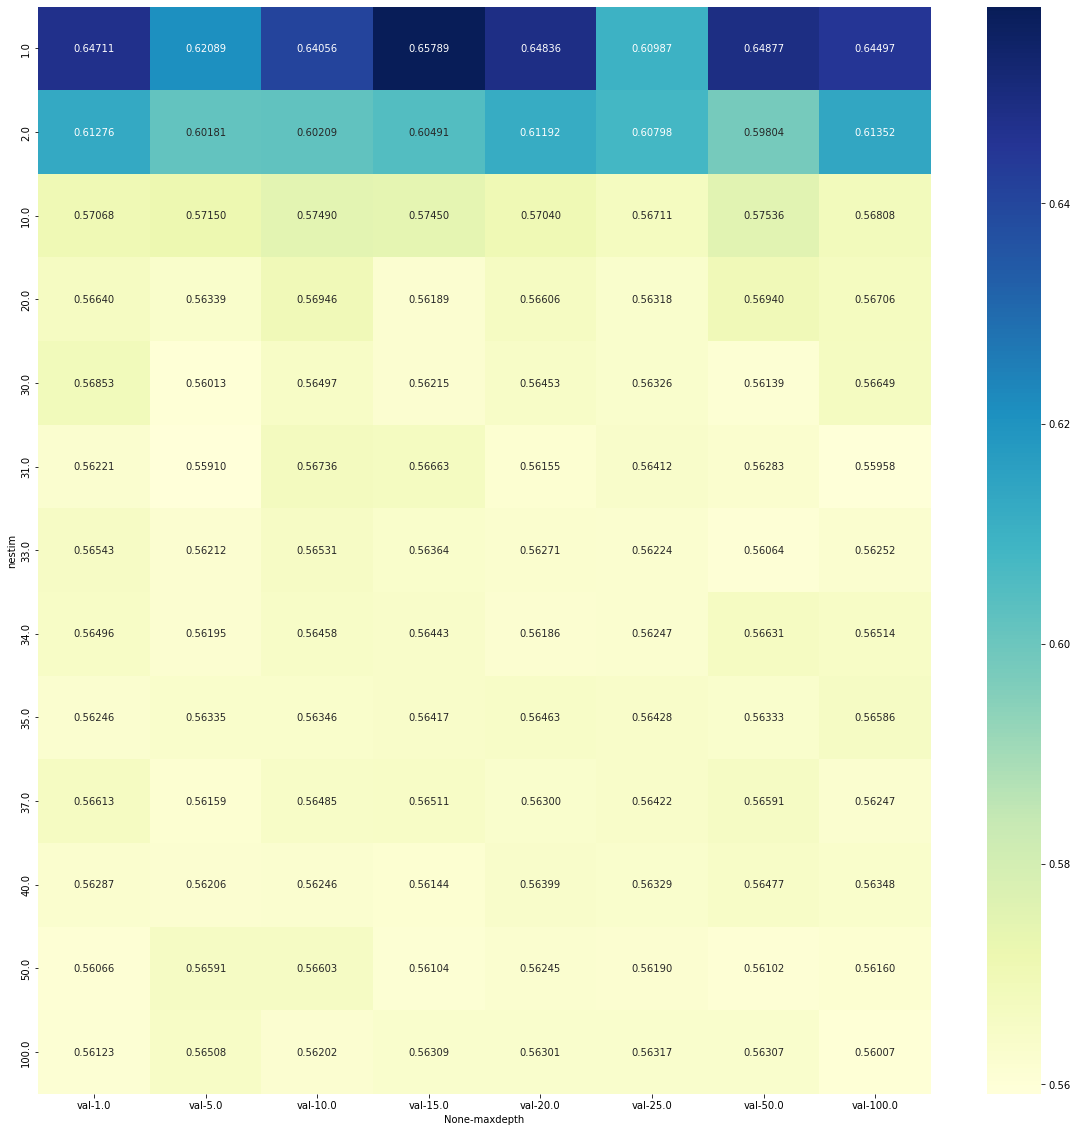

In [173]:
plt.figure(figsize=(20,20))
df_rf_pivot = df_rf.pivot(index='nestim', columns=['maxdepth'], values=['val'])
sns.heatmap(df_rf_pivot, annot=True, fmt=".5f",cmap="YlGnBu")

In [176]:
# test run with default vals
pipeline_rfr_regression = Pipeline([
    ('transformer', transf),
    ('rfr', RandomForestRegressor(max_depth=5, n_estimators=31))
])
pipeline_rfr_regression.fit(df_train, y_train)
eval_method(y_train,y_val,pipeline_rfr_regression.predict,'RF-madep5nest31')
df_reg_res


RF-madep5nest31
	Training RMSE: 0.529 
	Validation RMSE: 0.559 


,LinearRegression-default,SVR-default,SVR-C0.9eps0.15,DT-default,DT-maxdep3,RF-default,RF-madep5nest34,RF-madep2nest89,RF-madep5nest31
train,0.522273,0.502043,0.502613,0.344086,0.562987,0.372921,0.528873,0.573620,0.529143
val,0.559898,0.545259,0.545021,0.655376,0.564742,0.564084,0.557415,0.574794,0.558589


#### elasticNet

In [179]:
# speed run with default vals
pipeline = Pipeline([
    ('transformer', transf),
    ('en', ElasticNet())
])
pipeline.fit(df_train, y_train)
eval_method(y_train,y_val,pipeline.predict,'EN-default')
df_reg_res


EN-default
	Training RMSE: 1.293 
	Validation RMSE: 1.278 


,LinearRegression-default,SVR-default,SVR-C0.9eps0.15,DT-default,DT-maxdep3,RF-default,RF-madep5nest34,RF-madep2nest89,RF-madep5nest31,EN-default
train,0.522273,0.502043,0.502613,0.344086,0.562987,0.372921,0.528873,0.573620,0.529143,1.293389
val,0.559898,0.545259,0.545021,0.655376,0.564742,0.564084,0.557415,0.574794,0.558589,1.277913


In [184]:
df_en = pd.DataFrame(columns=['a','l1','train','val'])
for a in np.logspace(-5,-1,10):
    for l1 in np.linspace(0,0.5,10):
        # speed run with default vals
        pipeline = Pipeline([
            ('transformer', transf),
            ('en', ElasticNet(alpha=a,l1_ratio=l1))
        ])
        pipeline.fit(df_train, y_train)
        v = eval_method_noadd(y_train,y_val,pipeline.predict)
        df_en = df_en.append({'a': a, 'l1':l1,'train':v[0],'val':v[1]},ignore_index=True)
df_en

C:\Users\kay_t\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045.2569561938344, tolerance: 1.4867533221138227
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\kay_t\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 991.8688965772216, tolerance: 1.4867533221138227
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\kay_t\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarn

,a,l1,train,val
0,0.00001,0.000000,0.522298,0.559453
1,0.00001,0.055556,0.522299,0.559432
2,0.00001,0.111111,0.522299,0.559410
3,0.00001,0.166667,0.522300,0.559385
4,0.00001,0.222222,0.522301,0.559359
...,...,...,...,...
95,0.10000,0.277778,0.620265,0.615166
96,0.10000,0.333333,0.620640,0.615129
97,0.10000,0.388889,0.621236,0.615291
98,0.10000,0.444444,0.622056,0.615649


<AxesSubplot:xlabel='None-l1', ylabel='a'>

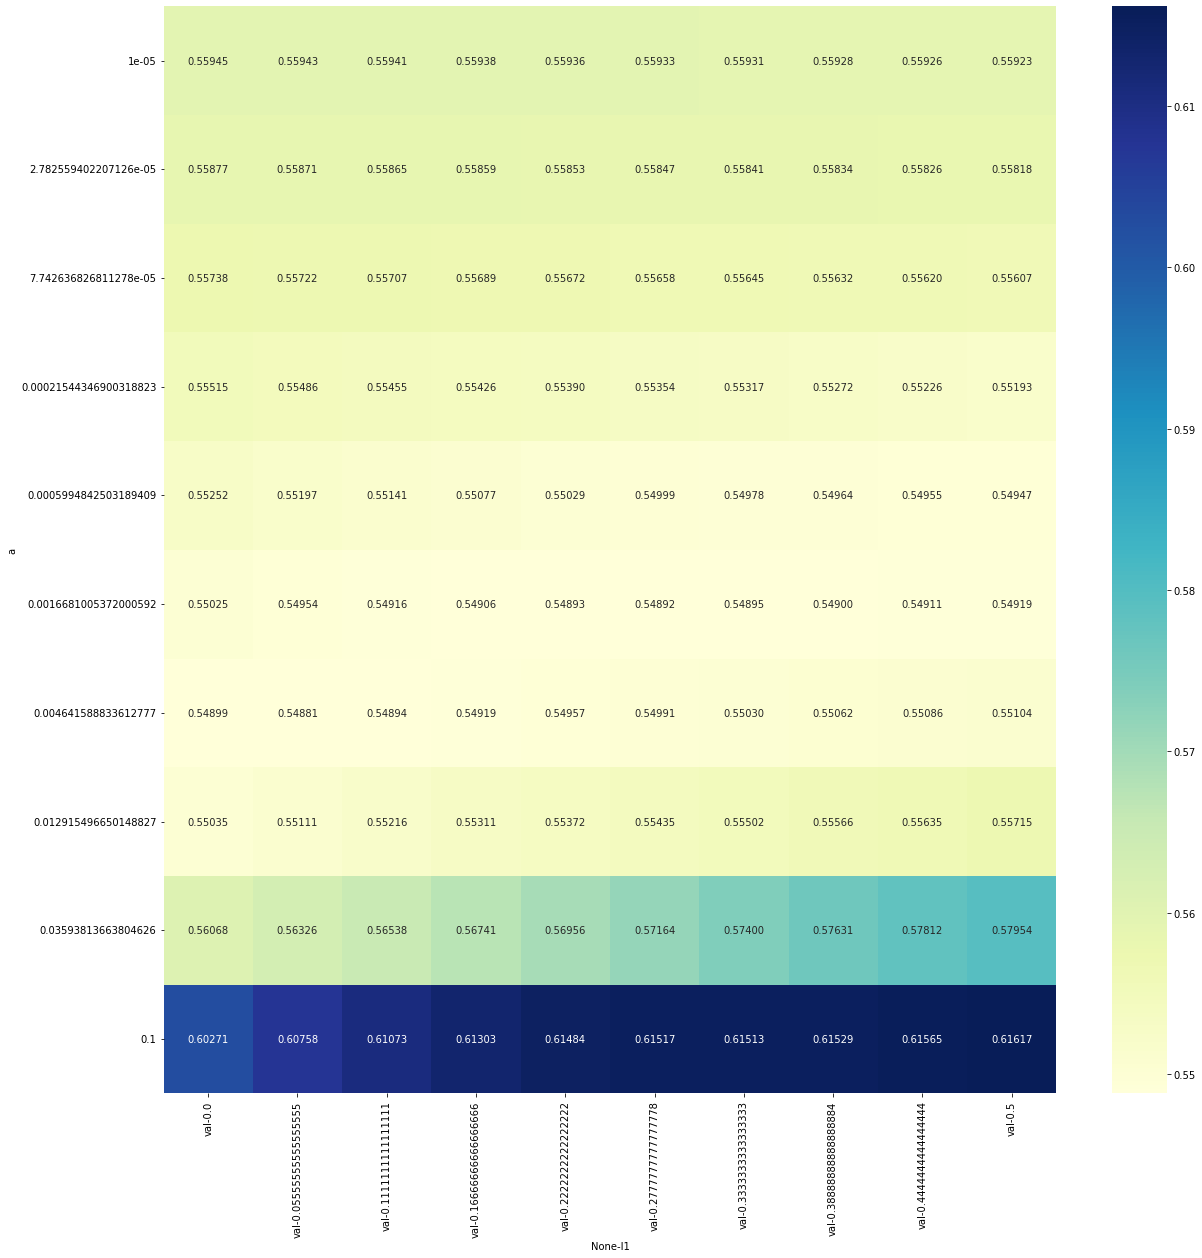

In [185]:
plt.figure(figsize=(20,20))
df_en_pivot = df_en.pivot(index='a', columns=['l1'], values=['val'])
sns.heatmap(df_en_pivot, annot=True, fmt=".5f",cmap="YlGnBu")

In [186]:
# speed run with default vals
pipeline = Pipeline([
    ('transformer', transf),
    ('en', ElasticNet(alpha=0.004, l1_ratio=0.055))
])
pipeline.fit(df_train, y_train)
eval_method(y_train,y_val,pipeline.predict,'EN-a0.04lone0.05')
df_reg_res


EN-a0.04lone0.05
	Training RMSE: 0.537 
	Validation RMSE: 0.549 


,LinearRegression-default,SVR-default,SVR-C0.9eps0.15,DT-default,DT-maxdep3,RF-default,RF-madep5nest34,RF-madep2nest89,RF-madep5nest31,EN-default,EN-a0.04lone0.05
train,0.522273,0.502043,0.502613,0.344086,0.562987,0.372921,0.528873,0.573620,0.529143,1.293389,0.537431
val,0.559898,0.545259,0.545021,0.655376,0.564742,0.564084,0.557415,0.574794,0.558589,1.277913,0.548775


#### Gradient Boosting Regressor


In [189]:
# speed run with default vals
pipeline = Pipeline([
    ('transformer', transf),
    ('gb', GradientBoostingRegressor())
])
pipeline.fit(df_train, y_train)
eval_method(y_train,y_val,pipeline.predict,'GB-default')
df_reg_res


GB-default
	Training RMSE: 0.511 
	Validation RMSE: 0.544 


,LinearRegression-default,SVR-default,SVR-C0.9eps0.15,DT-default,DT-maxdep3,RF-default,RF-madep5nest34,RF-madep2nest89,RF-madep5nest31,EN-default,EN-a0.04lone0.05,GB-default
train,0.522273,0.502043,0.502613,0.344086,0.562987,0.372921,0.528873,0.573620,0.529143,1.293389,0.537431,0.511446
val,0.559898,0.545259,0.545021,0.655376,0.564742,0.564084,0.557415,0.574794,0.558589,1.277913,0.548775,0.544403


In [198]:
df_t = pd.DataFrame(columns=['lr','n_est','train','val'])
for n_est in [1,10,20,50,100,200,500,1000,2000,50000]:
    for lr in np.logspace(-3,-1,5):
        # speed run with default vals
        pipeline = Pipeline([
            ('transformer', transf),
            ('gb', GradientBoostingRegressor(learning_rate=lr,n_estimators=n_est))
        ])
        pipeline.fit(df_train, y_train)
        v = eval_method_noadd(y_train,y_val,pipeline.predict)
        df_t = df_t.append({'lr': lr, 'n_est':n_est,'train':v[0],'val':v[1]},ignore_index=True)
df_t

,lr,n_est,train,val
0,0.001000,1.0,1.393099,1.377252
1,0.003162,1.0,1.390576,1.374762
2,0.010000,1.0,1.382606,1.366891
3,0.031623,1.0,1.357462,1.342064
4,0.100000,1.0,1.278610,1.264231
5,0.001000,10.0,1.382658,1.366943
6,0.003162,10.0,1.357979,1.342576
7,0.010000,10.0,1.283626,1.269169
8,0.031623,10.0,1.082533,1.071027
9,0.100000,10.0,0.711560,0.709553


<AxesSubplot:xlabel='None-n_est', ylabel='lr'>

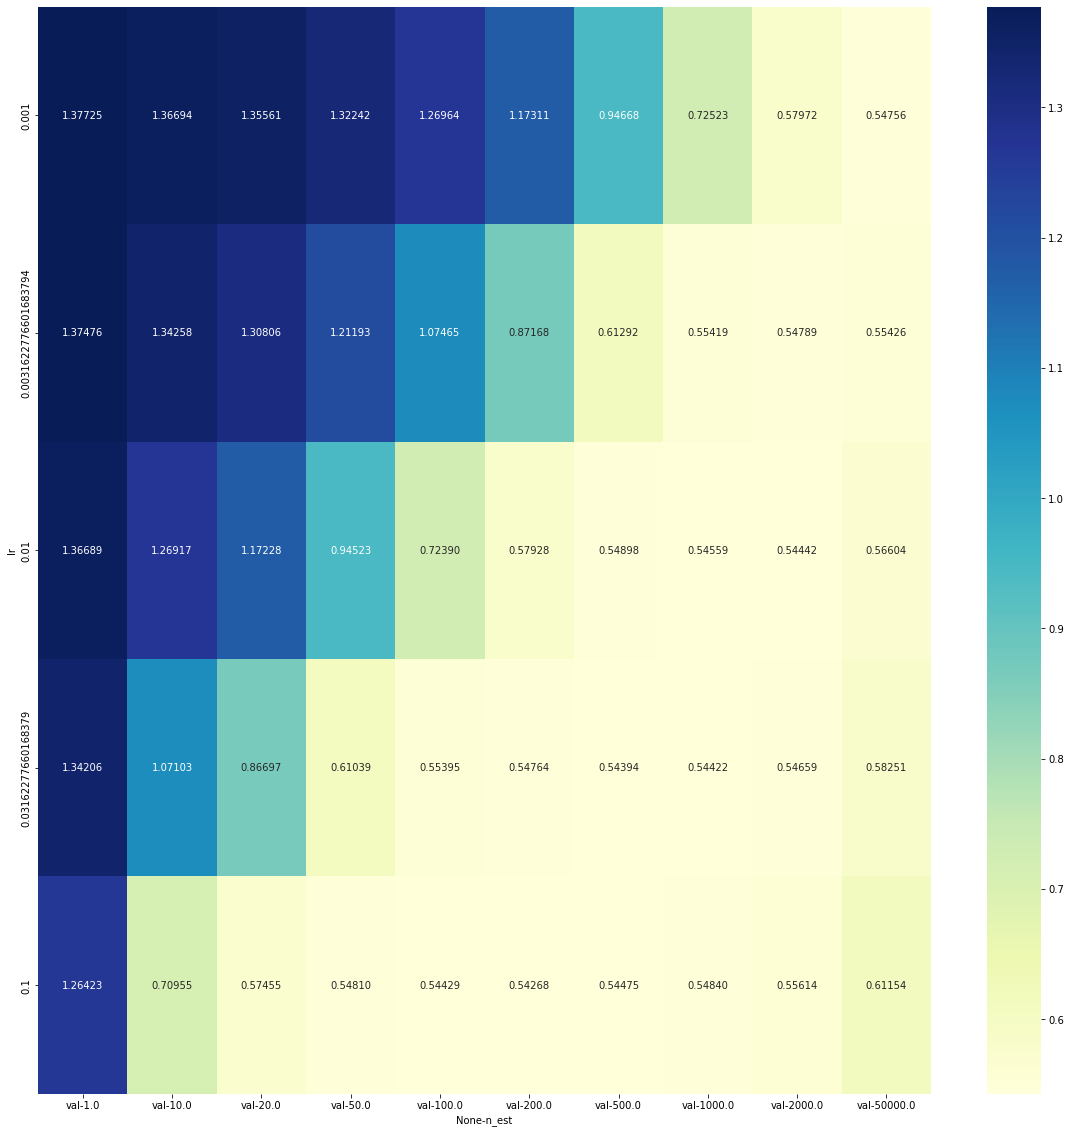

In [200]:
plt.figure(figsize=(20,20))
df_t_pivot = df_t.pivot(index='lr', columns=['n_est'], values=['val'])
sns.heatmap(df_t_pivot, annot=True, fmt=".5f",cmap="YlGnBu")

In [201]:
# speed run with default vals
pipeline = Pipeline([
    ('transformer', transf),
    ('gb', GradientBoostingRegressor(learning_rate=0.03,n_estimators=1000 ))
])
pipeline.fit(df_train, y_train)
eval_method(y_train,y_val,pipeline.predict,'GB-lr003nest1000')
df_reg_res


GB-lr003nest1000
	Training RMSE: 0.495 
	Validation RMSE: 0.544 


,LinearRegression-default,SVR-default,SVR-C0.9eps0.15,DT-default,DT-maxdep3,RF-default,RF-madep5nest34,RF-madep2nest89,RF-madep5nest31,EN-default,EN-a0.04lone0.05,GB-default,GB-lr003nest1000
train,0.522273,0.502043,0.502613,0.344086,0.562987,0.372921,0.528873,0.573620,0.529143,1.293389,0.537431,0.511446,0.494942
val,0.559898,0.545259,0.545021,0.655376,0.564742,0.564084,0.557415,0.574794,0.558589,1.277913,0.548775,0.544403,0.544177


#### xgboost

In [218]:
import xgboost as xgb

In [219]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False) #import encoder

# Serialize non-numerical data using DictVectorizer (aka One-Hot Encoding)
train_dict = df_train.to_dict(orient='records') # get categorial variables from train db, sort them by x and put them into dictionary 
X_train = dv.fit_transform(train_dict) #one-hot encoding 

In [277]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names = dv.get_feature_names())
dval = xgb.DMatrix(X_val,label=y_val, feature_names = dv.get_feature_names())

xgb_params = {
    'eta': 0.3, 
    'tree_method':'gpu_hist',
    'max_depth': 10,
    'gpu_id':0,
    
    'objective': 'reg:squarederror',
    'nthread': 16,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

C:\Users\kay_t\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [278]:
#parser
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [279]:
%%capture output1
xgb_params['eta'] = 0.1;
model = xgb.train(xgb_params, dtrain, num_boost_round=500, verbose_eval=1, evals=watchlist)


In [280]:
df_score = parse_xgb_output(output1)
df_score

,num_iter,train_rmse,val_rmse
0,0,3.69994,3.99187
1,1,3.33108,3.90862
2,2,2.99903,3.81912
3,3,2.70005,3.74400
4,4,2.43093,3.68358
...,...,...,...
495,495,0.00515,3.09162
496,496,0.00515,3.09159
497,497,0.00514,3.09159
498,498,0.00513,3.09158


XGBoost has 3 as val RMSE

#### Summary
In Summary:

In [281]:
df_reg_res

,LinearRegression-default,SVR-default,SVR-C0.9eps0.15,DT-default,DT-maxdep3,RF-default,RF-madep5nest34,RF-madep2nest89,RF-madep5nest31,EN-default,EN-a0.04lone0.05,GB-default,GB-lr003nest1000
train,0.522273,0.502043,0.502613,0.344086,0.562987,0.372921,0.528873,0.573620,0.529143,1.293389,0.537431,0.511446,0.494942
val,0.559898,0.545259,0.545021,0.655376,0.564742,0.564084,0.557415,0.574794,0.558589,1.277913,0.548775,0.544403,0.544177


Therefore, the best method is GB/lr=0.03 and n_est = 1000

# Export model

In [361]:
import pickle

transformations = [
    ('Scal_num', RobustScaler() , feat_num),
    ('categorical', OneHotEncoder(dtype=np.int32,handle_unknown = 'ignore'), feat_cat)
]

transf = ColumnTransformer(transformations, remainder='drop')

# speed run with default vals
pipeline = Pipeline([
    ('transformer', transf),
    ('gb', GradientBoostingRegressor(max_depth=1000,learning_rate=0.03))
])

pipeline.fit(df_train, y_train)

with open("pipeline.bin", 'wb') as f:  pickle.dump(pipeline,f)

# Testing Flask app

In [362]:
# client.py: get data of the new user
import requests
import json


id =20 #select here an id to test!
example = df_test.iloc[id:id+1,:].to_json()
expected_res = y_test[id]



url = "http://127.0.0.1:9696/predict"
results = requests.post(url, json=example).json()
print(df_test.iloc[id:id+1,:])
print("Price for ID %d : %f" % (id, results["log_price"]))

print("Database results: %f" % expected_res)

                                     category  room_count  bathroom_count  \
20  Shops, Businesses and Industrial Premises         5.0             3.0   

      size      type      city   region  
20  1000.0  For rent  Kairouan  Chebika  
Price for ID 20 : 3.467243
Database results: 3.477121


In [364]:
with open("y_test.bin", 'wb') as f:  pickle.dump(y_test,f)

## Final Output (release)

In [90]:
# client.py: get data of the new user
import requests
import json


id =34 #select here an id to test!
example = df_test.iloc[id:id+1,:].to_json()
expected_res = y_test[id]



url = "http://127.0.0.1:9696/predict"
results = requests.post(url, json=example).json()
print(df_test.iloc[id:id+1,:])
log_price = results["log_price"]

#print("logprice:" , log_price)
print("Price for ID %d : ~%d TND [log_price: %2.3f]" % (id, 10**log_price, log_price))
#print("actual price: %d TND" % 10**expected_res)


          category  room_count  bathroom_count  size      type    city  region
34  Land and Farms        -1.0            -1.0  -1.0  For sale  Mahdia  Mahdia
Price for ID 34 : ~408859 TND [log_price: 5.612]


# Cloud

In [103]:
# client.py: get data of the new user
import requests
import json


id =34 #select here an id to test!
example = df_test.iloc[id:id+1,:].to_json()
expected_res = y_test[id]



url="https://kallelay.eu.pythonanywhere.com/predict"
results = requests.post(url, json=example).json()
#print(df_test.iloc[id:id+1,:])
log_price = results["log_price"]

#print("logprice:" , log_price)
print("Price for ID %d : ~%d TND [log_price: %2.3f]" % (id, 10**log_price, log_price))
#print("actual price: %d TND" % 10**expected_res)


Price for ID 34 : ~408859 TND [log_price: 5.612]
